# Homework - EDA, DP & DR

***Agata Makarewicz***

*Week 2 & 3*

## Introduction

This notebook aims to analyse, preprocess and reduce dimension of the "Bank Marketing" dataset. 

https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

In [1]:
# loading packages 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

from sklearn.impute import SimpleImputer

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelBinarizer, LabelEncoder
import category_encoders
from category_encoders.target_encoder import TargetEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin
from sklearn.feature_selection import VarianceThreshold
import umap

import warnings
import random

random.seed(123)
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# loading the data
df = pd.read_csv('bank-additional-full.csv', sep=";")

## Exploratory Data Analysis

### Basic statistics and structure

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
# Checking data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [5]:
# making sure there are no missing values 
df.isnull().sum().where(lambda x: x!=0).count()

0

As we can see above, our data consists of 41188 observations described by 21 features, both numerical and categorical. It seems we have no missing values in our dataset, however, they appear in some categorical attributes, all coded with the "unknown" label. We will take care of them later. Let's now check if any of our records are duplicated.

In [6]:
# checking if there are duplicated records
df.duplicated().value_counts()

False    41176
True        12
dtype: int64

In [7]:
df[df.duplicated()==True]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
1266,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
12261,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
14234,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
16956,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,...,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
18465,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no
20216,55,services,married,high.school,unknown,no,no,cellular,aug,mon,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,no
20534,41,technician,married,professional.course,no,yes,no,cellular,aug,tue,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1,no
25217,39,admin.,married,university.degree,no,no,no,cellular,nov,tue,...,2,999,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8,no
28477,24,services,single,high.school,no,yes,no,cellular,apr,tue,...,1,999,0,nonexistent,-1.8,93.075,-47.1,1.423,5099.1,no
32516,35,admin.,married,university.degree,no,yes,no,cellular,may,fri,...,4,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no


In [8]:
df = df.drop_duplicates()

There are only 12 duplicated records, and given the size of our dataset, we don't need to worry about them so we drop them.

As we noticed before, we have both numerical and categorical variables in our data, so let's create two separate dataframes, containing features of given type, which will be useful in our further analysis and processing.

In [9]:
numerical = df.select_dtypes("number").columns
categorical = df.select_dtypes(object).columns

In [10]:
numerical

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')

In [11]:
categorical

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'y'],
      dtype='object')

In [12]:
# splitting data frame into two separate ones
df_num = df[numerical]
df_cat = df[categorical]

In [13]:
# basic statistics for continuous variables
df.describe() # or df_num.describe() - same result

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41176.00000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000
mean,40.02380,258.315815,2.567879,962.464810,0.173013,0.081922,93.575720,-40.502863,3.621293,5167.034870
std,10.42068,259.305321,2.770318,186.937102,0.494964,1.570883,0.578839,4.627860,1.734437,72.251364
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


Ending up this part, let's take a closer look at the target variable - y - which says whether the product (bank term deposit) would be ('yes') or not ('no') subscribed by given client.

[Text(0.5, 1.0, 'Distribution of target variable'), Text(0.5, 0, '')]

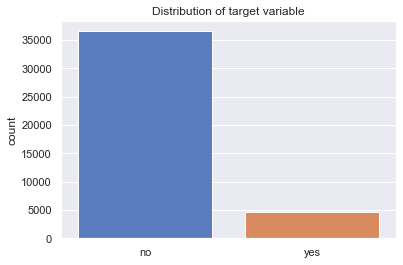

In [14]:
# target variable
sns.countplot(x="y", data=df, palette="muted").set(title='Distribution of target variable', xlabel="")

In [15]:
df.y.value_counts()

no     36537
yes     4639
Name: y, dtype: int64

In [16]:
# percentage of 'yes' values of target variable
(len(df[df.y=='yes'])/len(df))*100 

11.266271614532737

### Univariate analysis + relationship with target variable

#### Numerical variables

First let's define functions which we'll use in this part of analysis.

In [17]:
# function to plot both histogram & boxplot for given numerical variable
def plot_num(var,data):
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    plot1 = sns.histplot(data=data, x=var, ax=axes[0], kde=True) #, label='Skewness: %.2f' % (df[var].skew())) ?!?!?!?
    plot1.set_ylabel(axes[0].get_ylabel(), fontsize=14)
    plot1.set(xlabel="")
    plot1.set_title('Distribution of '+var, fontsize=18)
    plot2 = sns.boxplot(data=data, x=var, ax=axes[1])
    plot2.set_title('Boxplot of '+var, fontsize=18)
    plot2.set(xlabel="")
#     plot1.set_yticks(plot1.get_yticks().tolist())
#     plot1.set_xticks(plot1.get_xticks().tolist())
#     plot1.set_yticklabels(plot1.get_yticks(), size = 12)
#     plot1.set_xticklabels(plot1.get_xticks(), size = 12)
    plt.setp(axes[0].patches, linewidth=0) # delete borders of the bars
    # sns.set_context(rc = {'patch.linewidth': 0.0})    
    
# function to plot relationship between target variable and given one
def plot_num_relation(var, data):
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=var, y="y", data=data).set_title('Relationship between '+var+' and target variable', fontsize=15)
    #plot.set_yticklabels(plot.get_yticks(), size = 15)

# function to call both functions at once
def plot_num_both(var, data):
    plot_num(var, data)
    plot_num_relation(var, data)

Now we'll investigate each numerical variable separately, analysing its distribution, relationship with target and, if exist, outliers. Basic statistics of those variables were already presented in the first section.

**Age**

*client's age*

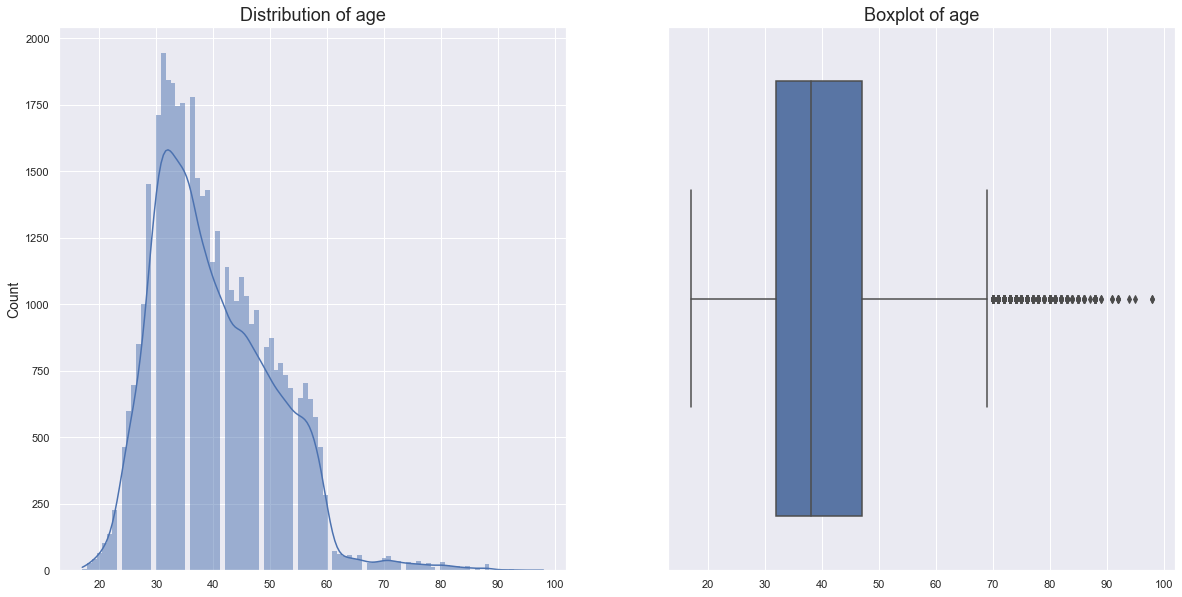

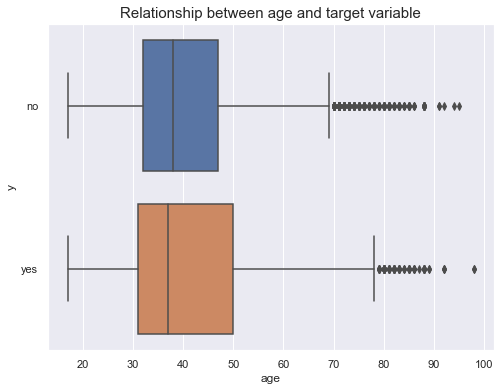

In [18]:
plot_num_both('age',df)

In [19]:
df.age.skew()

0.7845602604159753

"Age" has quite skewed distribution, but similar to normal, and also some outliers (values > 70). There no visible impact on target variable.

**Duration**

*last contact duration (seconds); this attribute highly affects the output target (e.g. if duration = 0 then y = 'no')*

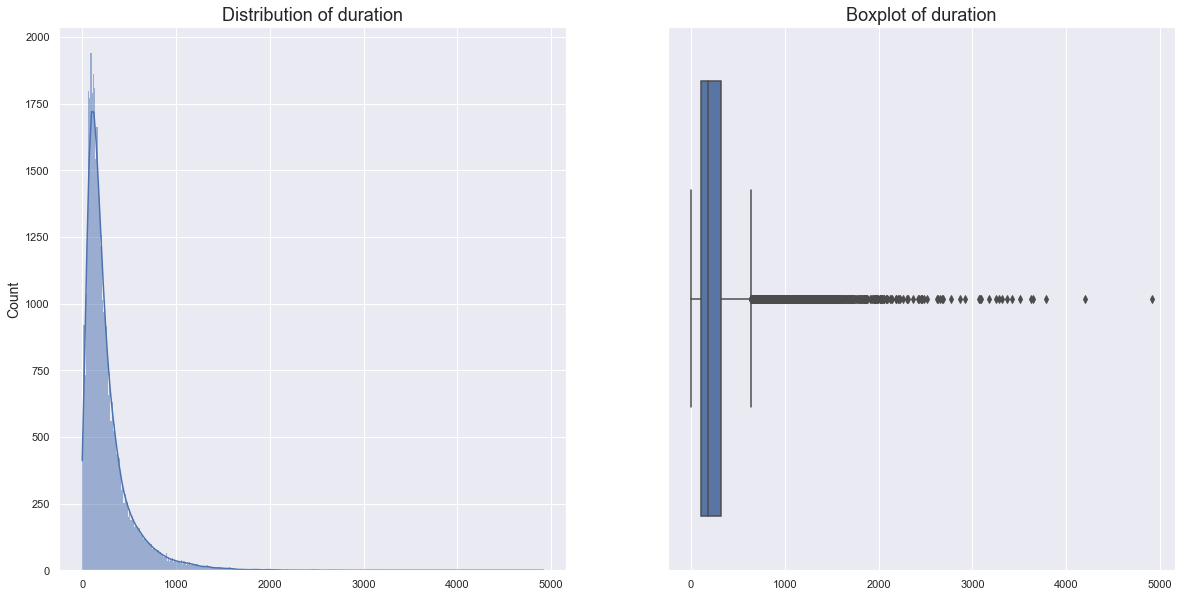

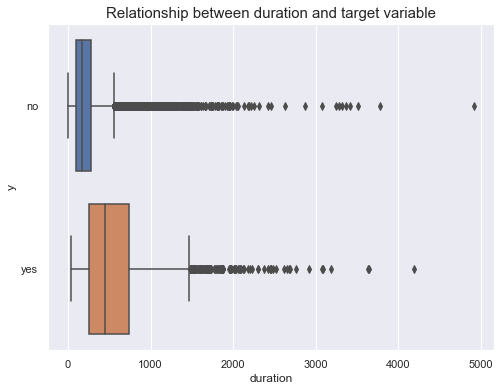

In [20]:
plot_num_both('duration', df)

Here we can observe a very heavy tail of "duration" distribution. Let's examine the distribution of duration up to 1000.

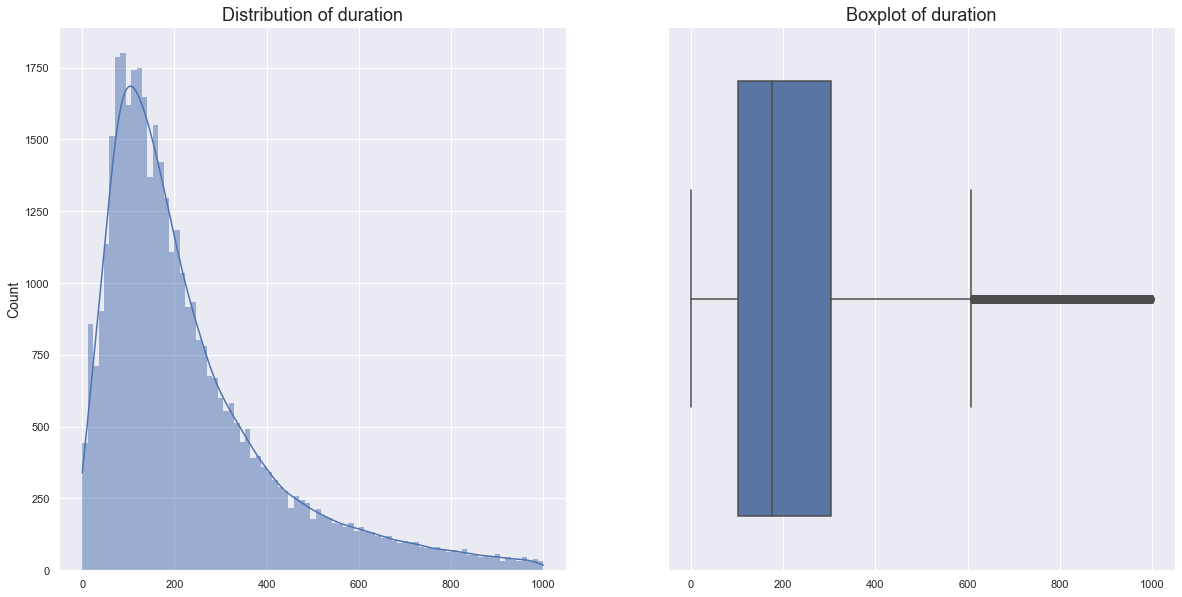

In [21]:
plot_num('duration',df[df.duration <= 1000])

In [22]:
temp = len(df[df.duration <= 1000])/len(df.duration)
print(temp*100)

97.67825918010492


So, as we can see, "duration" under 1000 covers almost 98% percent of our data, but still has a skewed distribution.

**Campaign**

*number of contacts performed during this campaign for a given client*

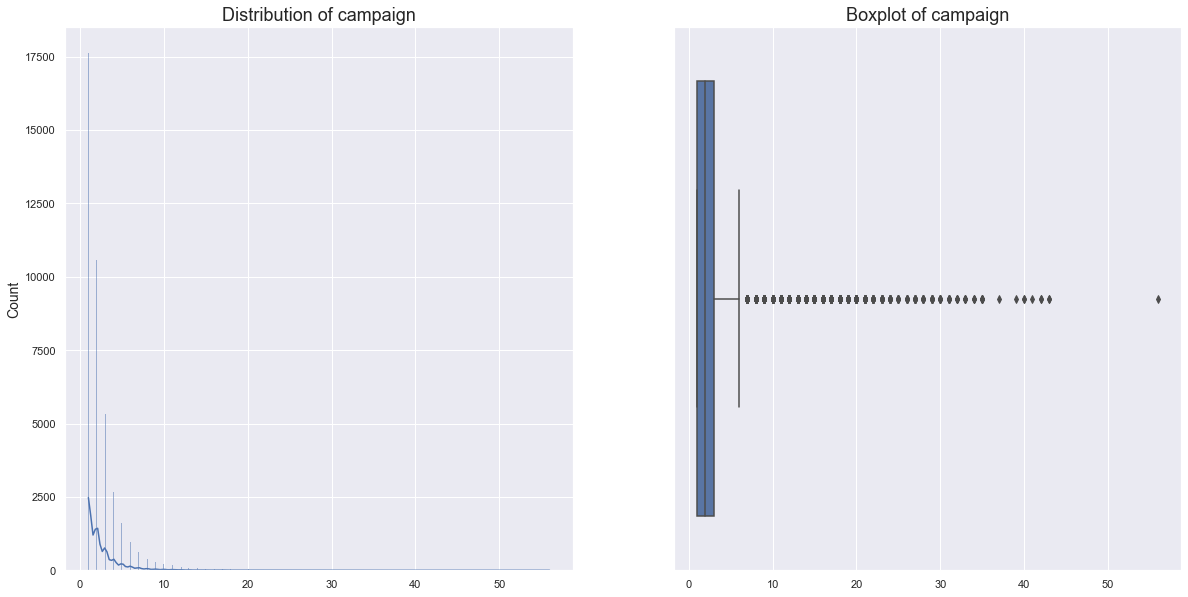

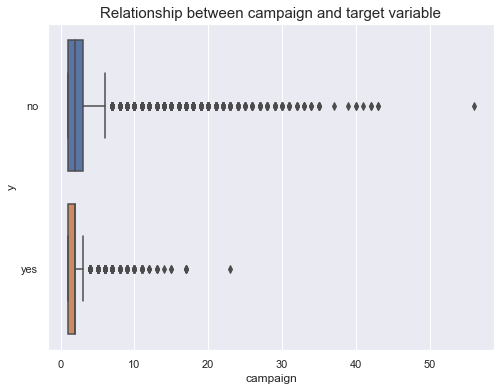

In [23]:
plot_num_both('campaign',df) 

In [24]:
df['campaign'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 19, 18, 23, 14,
       22, 25, 16, 17, 15, 20, 56, 39, 35, 42, 28, 26, 27, 32, 21, 24, 29,
       31, 30, 41, 37, 40, 33, 34, 43], dtype=int64)

This variable could be treated as ordinal, given its discrete values. There are some outliers visible (approximately values > 10).

**Pdays**

*number of days that passed by after the client was last contacted from a previous campaign (999 means client was not previously contacted)*

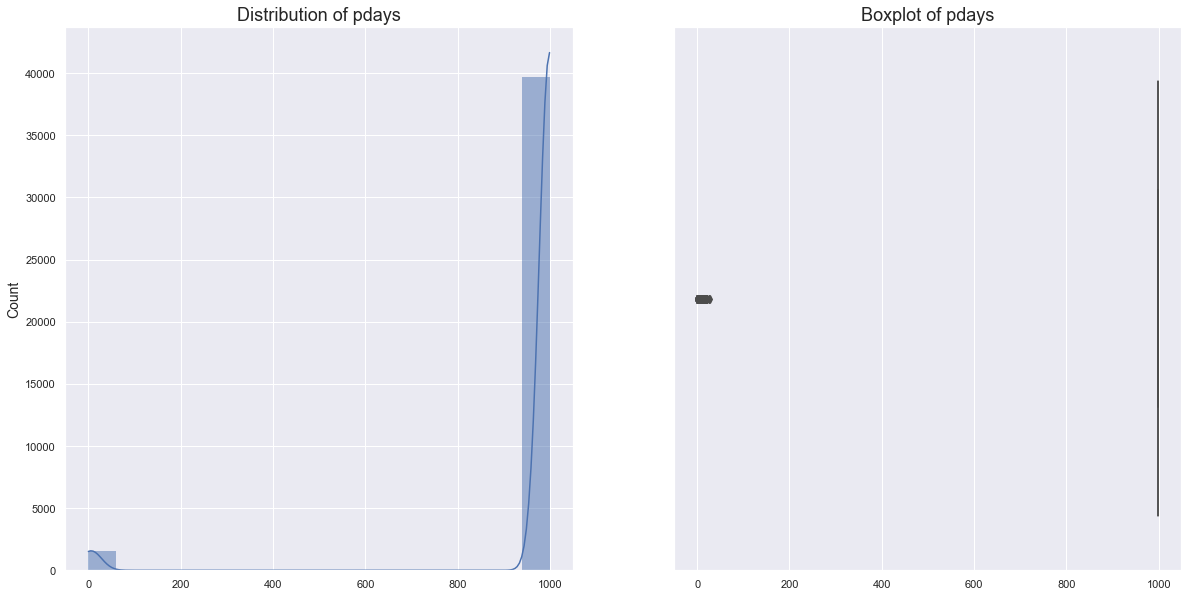

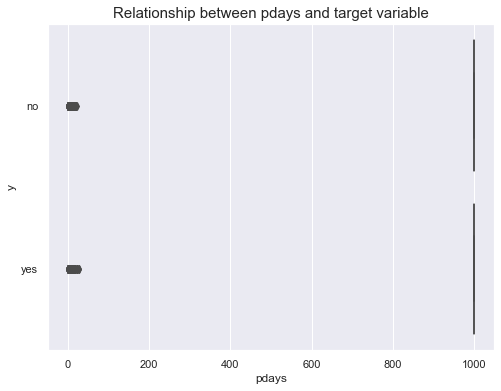

In [25]:
plot_num_both('pdays',df) 

In [26]:
print(df['pdays'].unique())
len(df[df.pdays==999])/len(df)

[999   6   4   3   5   1   0  10   7   8   9  11   2  12  13  14  15  16
  21  17  18  22  25  26  19  27  20]


0.9632067223625412

This variable also could be treated as ordinal, given its discrete values. However, 96% of values equal 999, meaning no previous contact. There is also no visible relation with the target variable, so this features gives us no meaningful information. 

**Previous**

*number of contacts performed before this campaign and for this client*

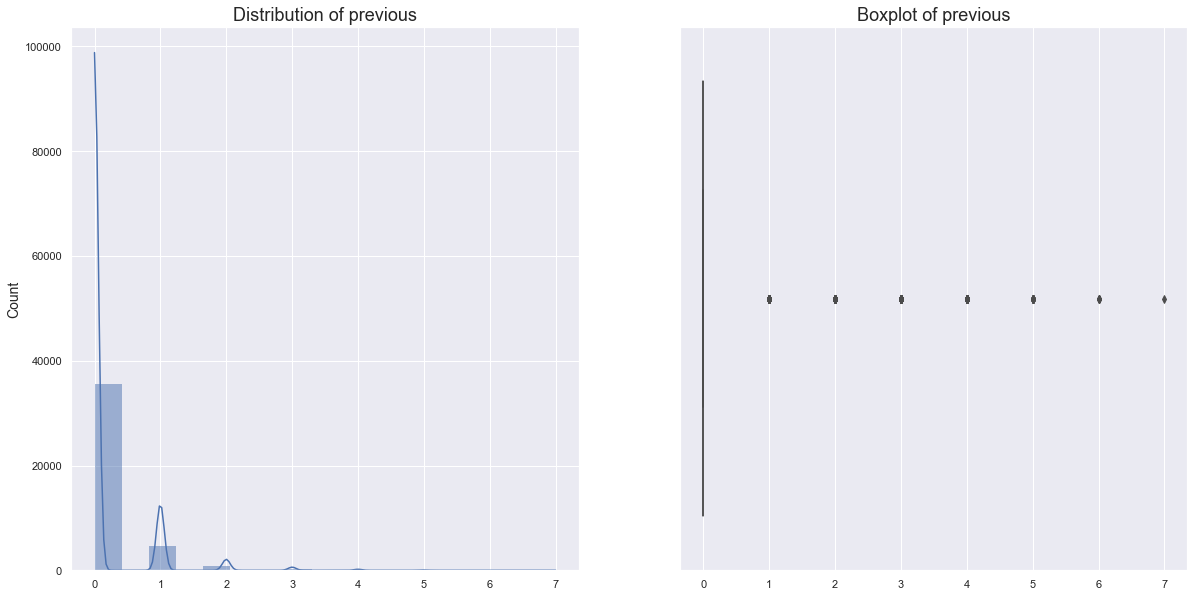

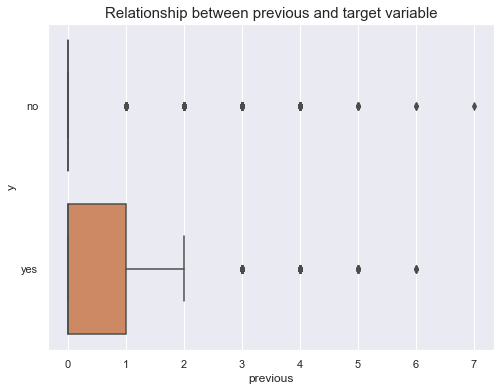

In [27]:
plot_num_both('previous',df)

In [28]:
len(df[df.previous<=2])/len(df)

0.9924713425296289

Another ordinal feature, with some outliers to drop.

**emp.var.rate**

*employment variation rate - quarterly indicator*

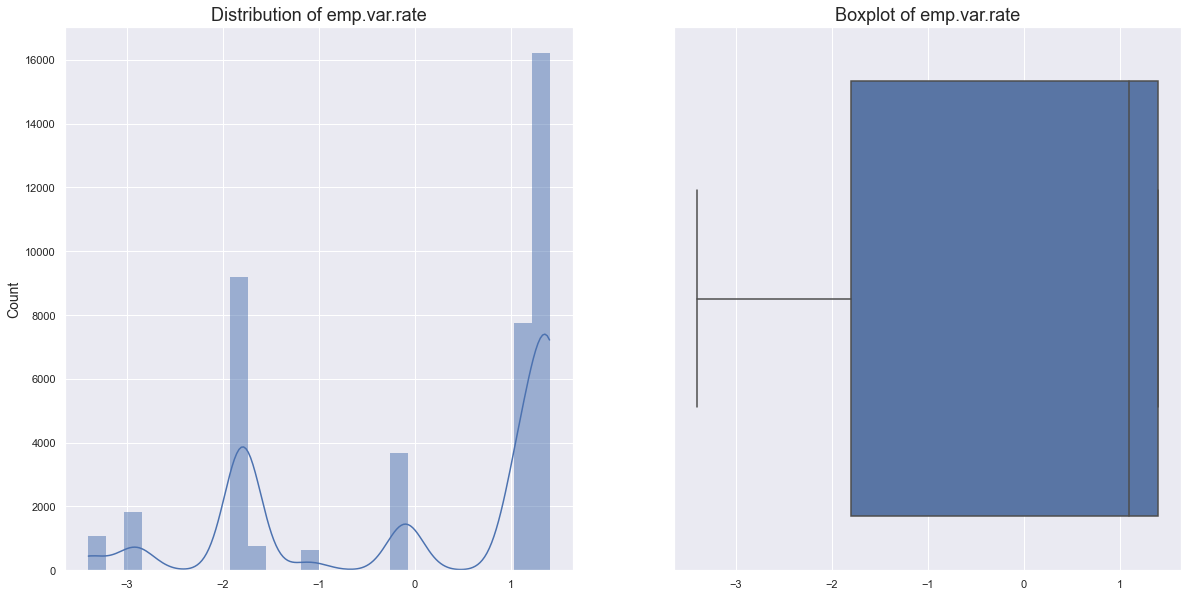

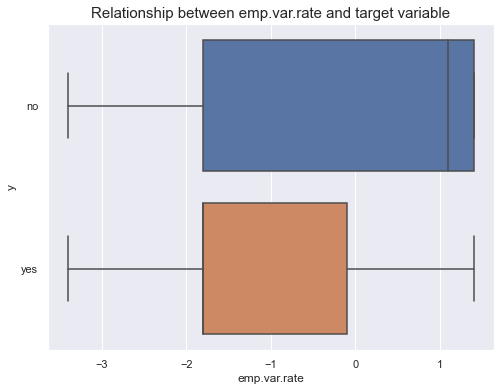

In [29]:
plot_num_both('emp.var.rate',df)

**cons.price.idx**

*consumer price index - monthly indicator*

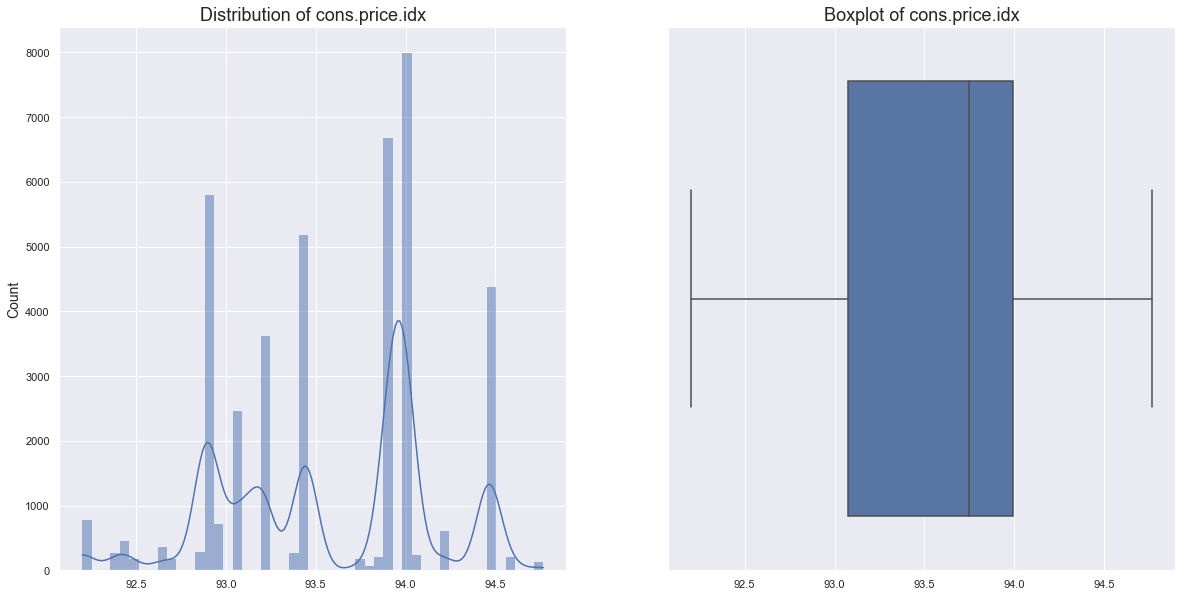

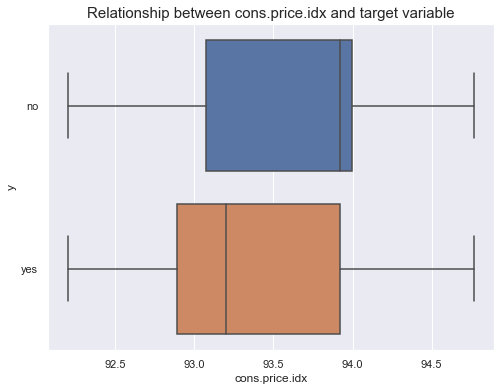

In [30]:
plot_num_both('cons.price.idx',df)

**cons.conf.idx**

*consumer confidence index - monthly indicator*

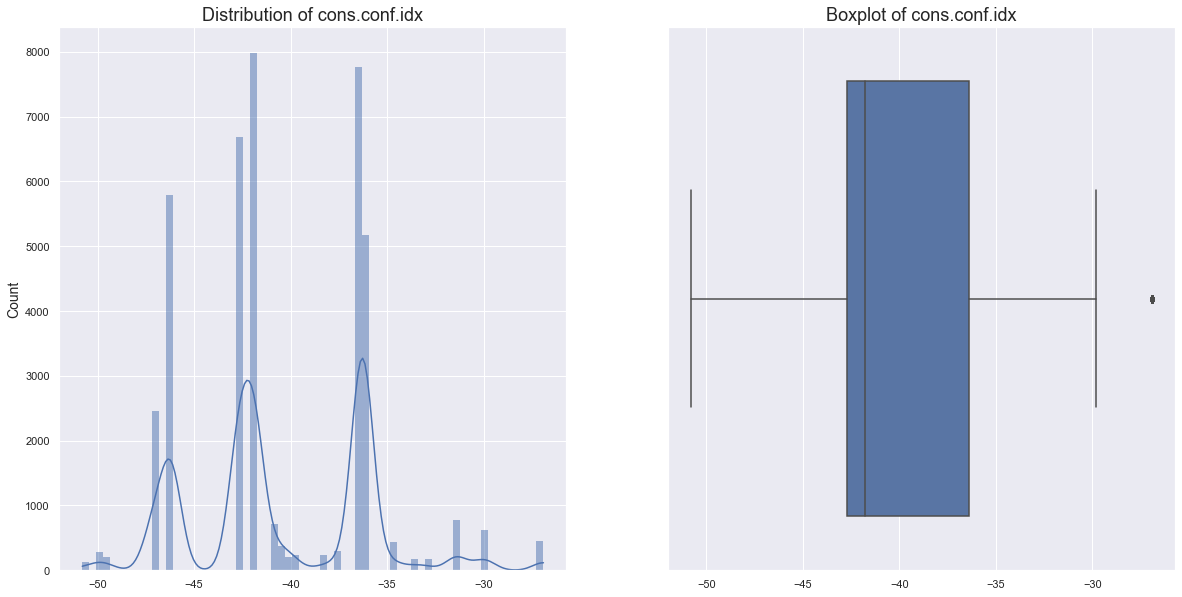

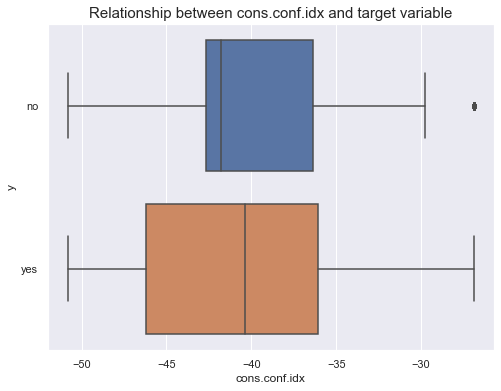

In [31]:
plot_num_both('cons.conf.idx',df)

**euribor3m**

*euribor 3 month rate - daily indicator*

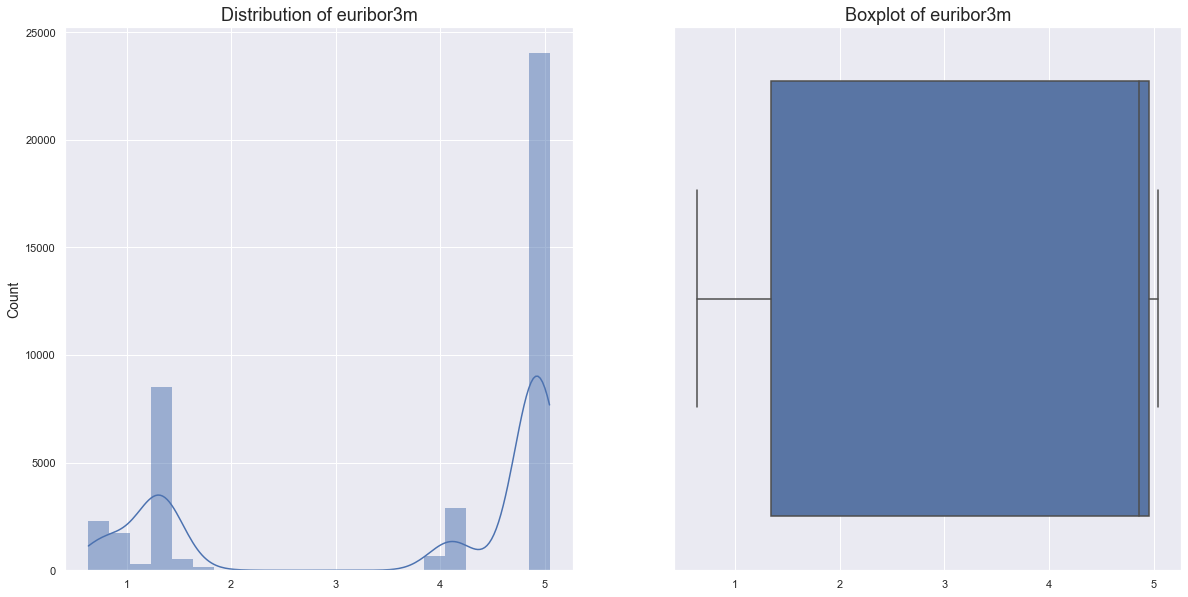

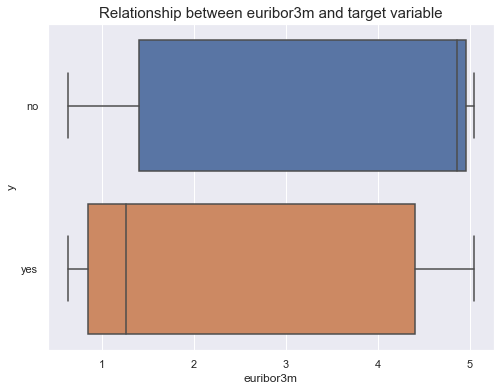

In [32]:
plot_num_both('euribor3m',df)

**nr.employed**

*number of employees - quarterly indicator*

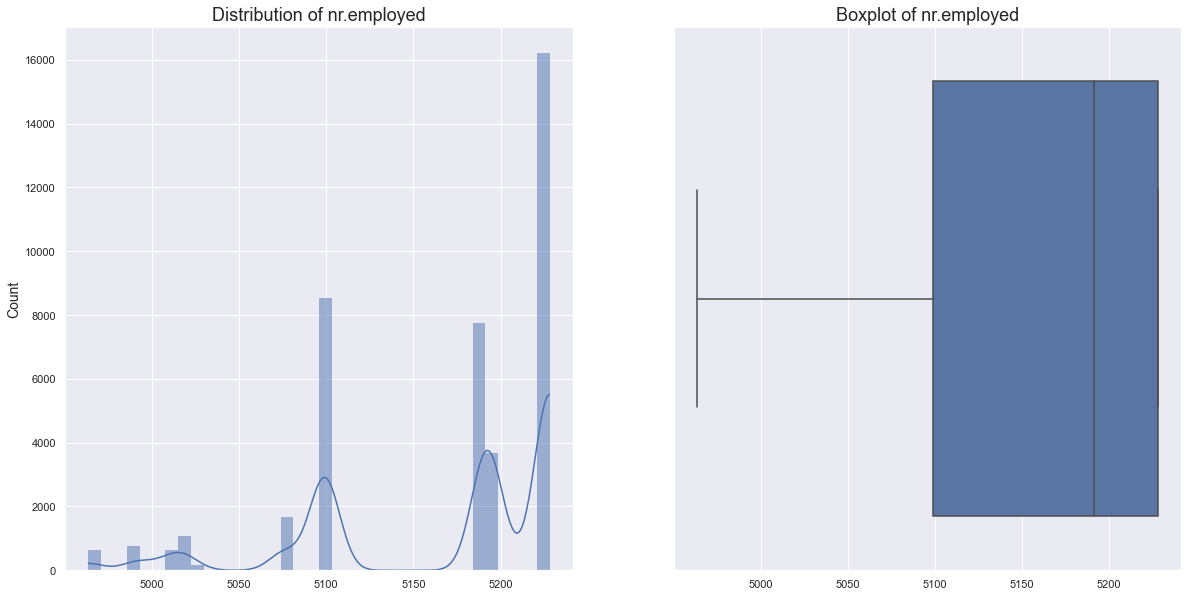

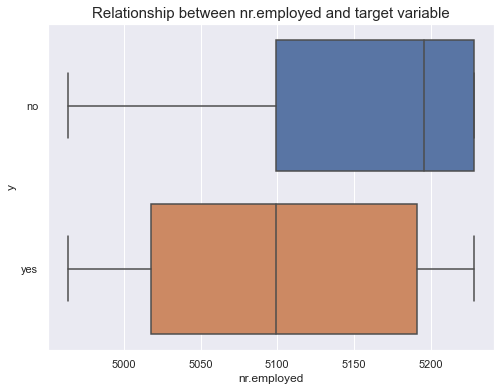

In [33]:
plot_num_both('nr.employed',df)

All five variables above have quite "original" distributions, but luckily, no outliers.

**Categorical variables**

Once again, let's first define functions which we'll be useful in this part of analysis.

In [34]:
# function to plot barplot for given categorical variable
def plot_cat(var, data, rot=False):
    plt.figure(figsize=(9,7))
    plot = sns.countplot(x=var, data=data, palette="muted")
    if rot:
        plot.set_xticklabels(plot.get_xticklabels(), rotation=30, ha="right")
    plot.set_title('Distribution of '+var, fontsize=14)
    plot.set(xlabel="")
    plt.tight_layout()
    
# function to plot relationship between target variable and given one
def plot_cat_relation(var, data, rot=False):
    data = df.groupby(var)["y"].value_counts(normalize=True).mul(100).rename('percent').reset_index()
    plot = sns.catplot(data=data, x=var, y='percent', hue="y", kind='bar', height=5, aspect=2, legend_out=False)
    if rot:
        plot.set_xticklabels(rotation=30, ha="right")
    plot.set(xlabel="", title='Relationship between '+var+' and target variable')
    plt.tight_layout()
    
# function to call both functions above at once
def plot_cat_both(var, data, rot=False):
    plot_cat(var, data, rot)
    plot_cat_relation(var, data, rot)

Now we'll investigate each categorical variable separately, analysing its distribution and relationship with target. The second one is presented in percentages, because, given the small fraction of 'yes' values of the target variable, normal charts with "Count" on the y axis are not very readable.

**Job**

*type of job*

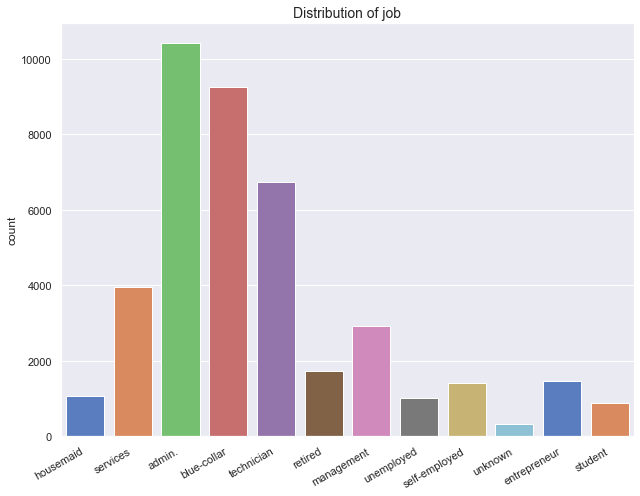

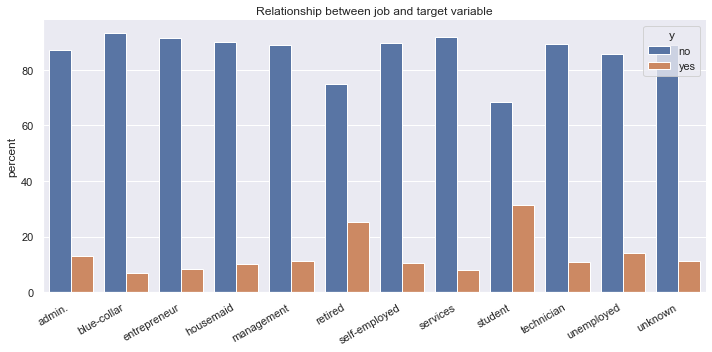

In [35]:
plot_cat_both('job',df,rot=True)

In [36]:
print(len(df[df.job=='unknown']))
print(len(df[df.job=='unknown'])/len(df))

330
0.008014377307169225


"Student" and "retired" have a much higher percentage of "yes" values of target variable, so we can expect this would be an influential feature. As for the missing values, there's a small number of those, given the size of the dataset, so we will probably drop them later on.

**Marital**

*marital status; 'divorced' means divorced or widowed*

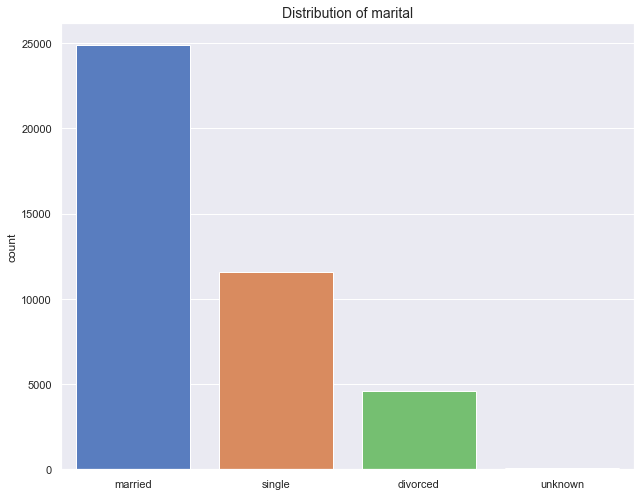

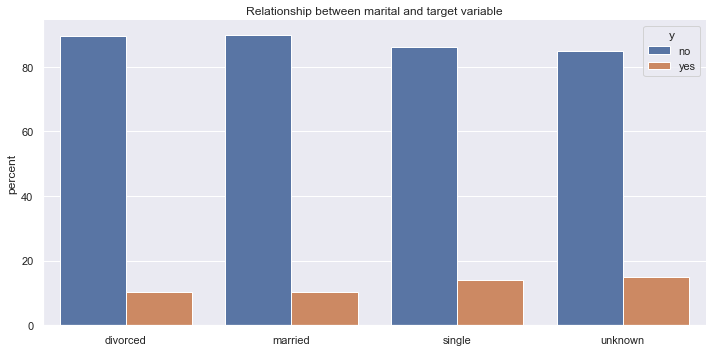

In [37]:
plot_cat_both('marital',df)

In [38]:
print(len(df[df.marital=='unknown']))
print(len(df[df.marital=='unknown'])/len(df))

80
0.0019428793471925393


There seems to be no relation between "marital" and target variable; missing are rare, so will be dropped.

**Education**

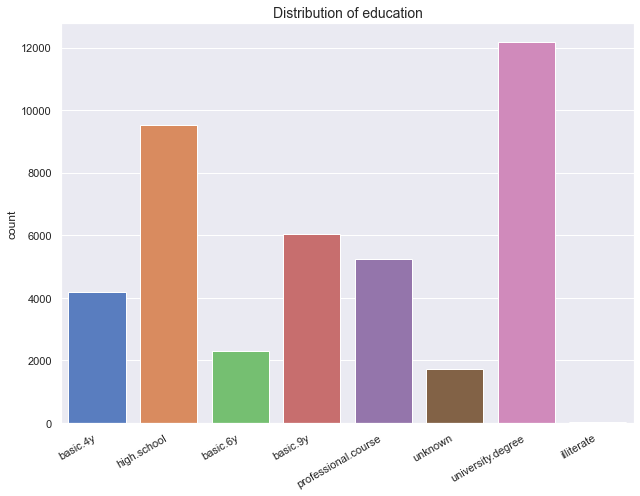

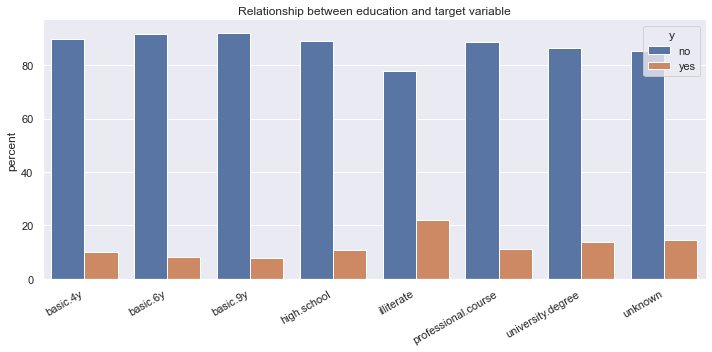

In [39]:
plot_cat_both('education',df, rot=True)

In [40]:
print(len(df[df.education=='illiterate']))
print(len(df[df.education=='unknown']))
print(len(df[df.education=='unknown'])/len(df))

18
1730
0.042014765883038666


"Illiterate" is very rare so we treat those records as outliers. As for missings, there's 4% of them, almost as much as one of the categories, so we will impute them.

**Default**

*has credit in default?*

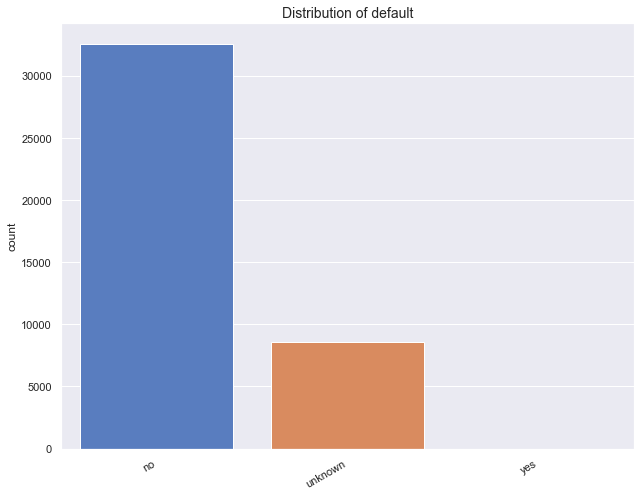

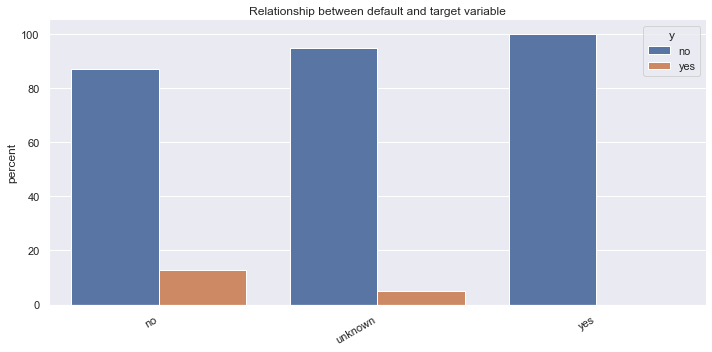

In [41]:
plot_cat_both('default',df, rot=True)

In [42]:
len(df[df.default=='yes']) 

3

This feautere should be dropped, because "yes" appears only 3 times (outliers), and no matter if we impute or drop the missing, we get a feature equal to "no" for each record.

**Housing**

*has housing loan?*

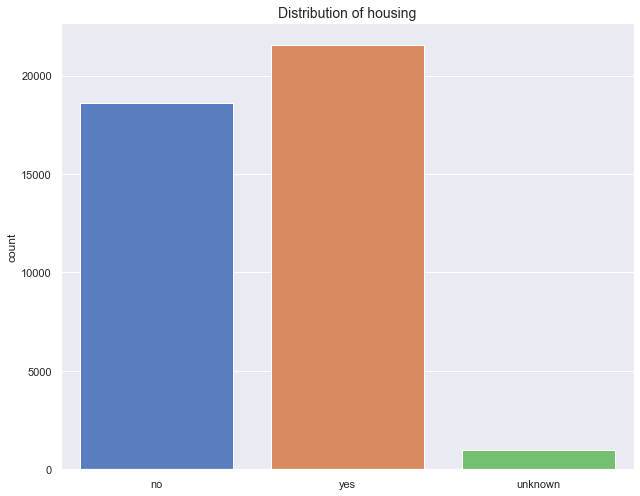

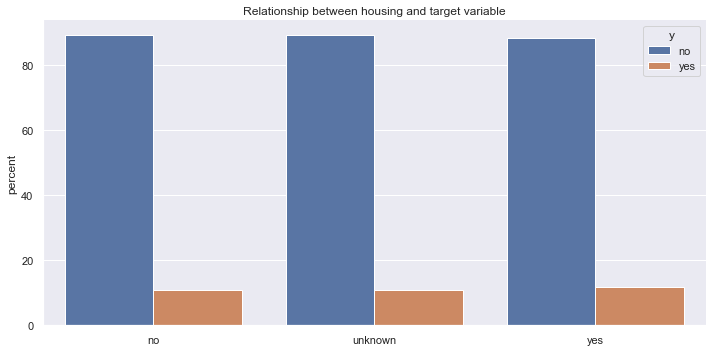

In [43]:
plot_cat_both('housing',df)

In [44]:
print(len(df[df.housing=='unknown']))
print(len(df[df.housing=='unknown'])/len(df))

990
0.024043131921507675


There are 2% missing values, we can impute them or drop. The first option is not very good, as we would impute them with mode ("yes") and the fraction of "yes" and "no" are quite similar here.

**Loan**

*has personal loan?*

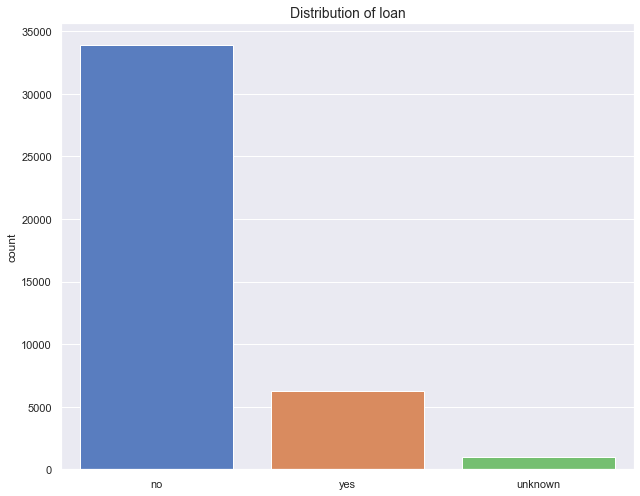

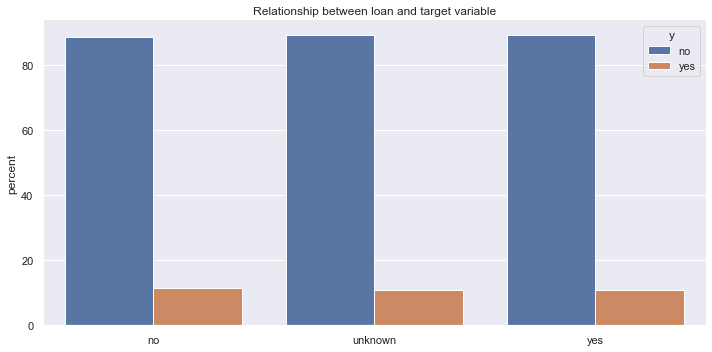

In [45]:
plot_cat_both('loan',df)

In [46]:
print(len(df[df.loan=='unknown']))
print(len(df[df.loan=='unknown'])/len(df))

990
0.024043131921507675


We can see that there's exactly the same number of missing as in "housing". Let's check if they're the same records.

In [47]:
df.loc[(df.loan=="unknown") & (df.housing=="unknown")].shape

(990, 21)

They are, so we just drop them.

**Contact**

*contact communication type*

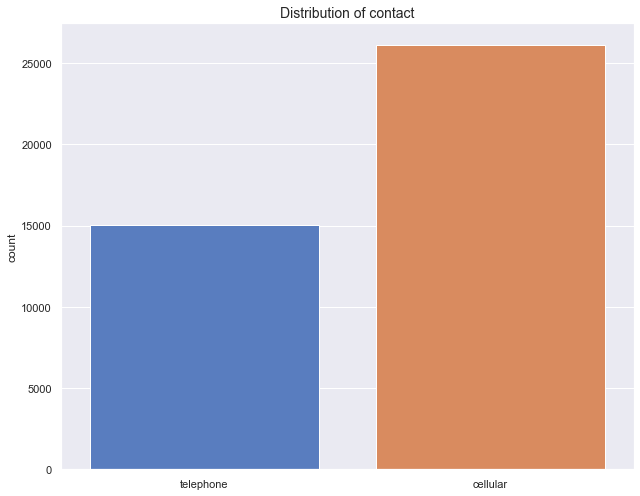

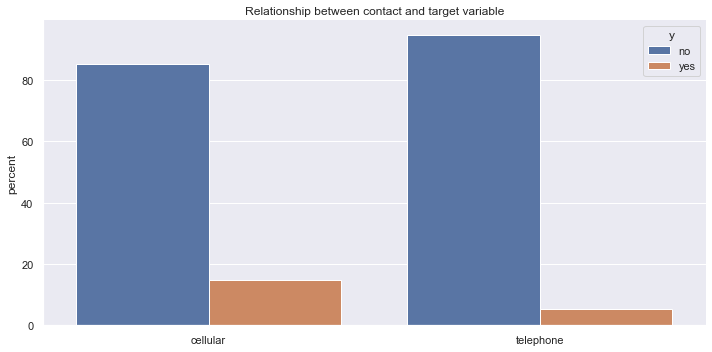

In [48]:
plot_cat_both('contact',df)

There's no clear correlation between those two variables.

**Month**

*last contact month of year*

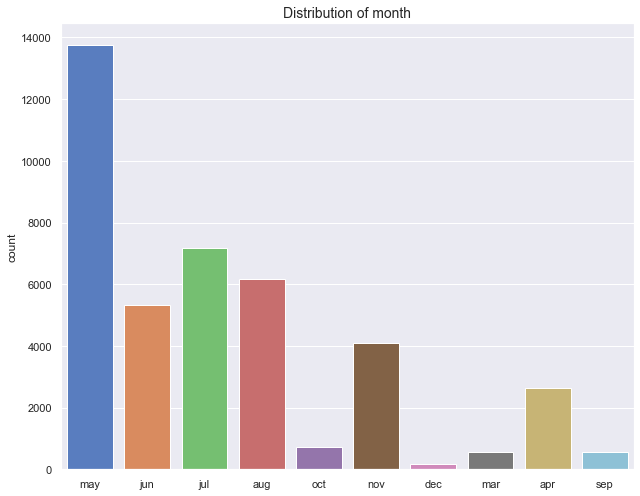

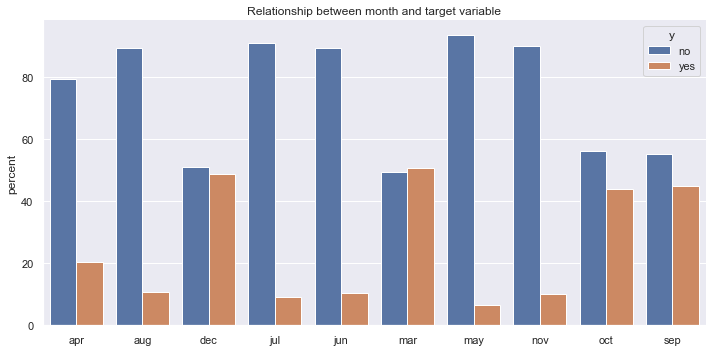

In [49]:
plot_cat_both('month',df) 

October, March, December and September appear rarely, however we will not drop them, instead encode them all as "other". Additionaly, this features seems to have impact on our target variable.

**Day_of_week**

*last contact day of the week*

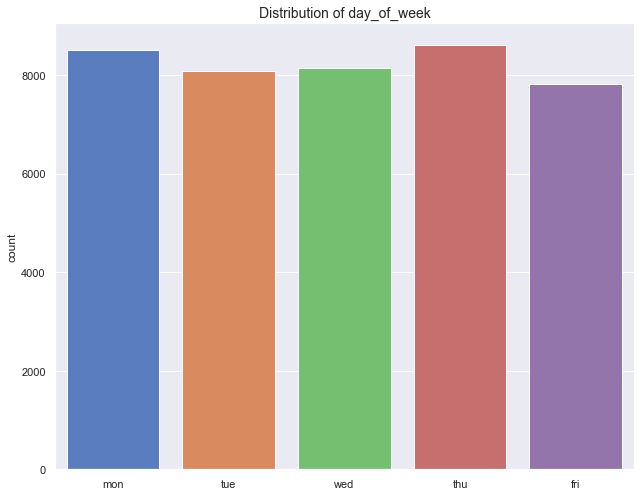

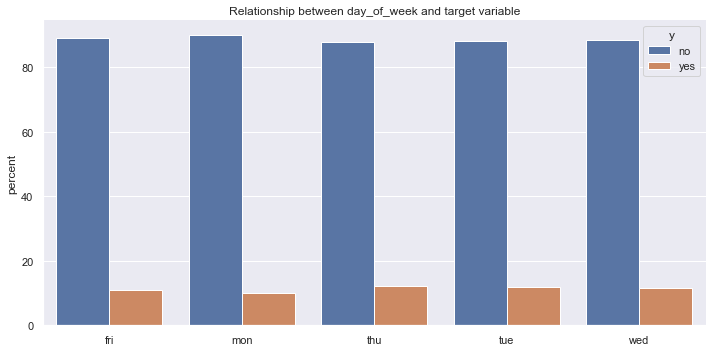

In [50]:
plot_cat_both('day_of_week',df)

Almost uniform distribution, and no relation to target variable.

**Poutcome**

*outcome of the previous marketing campaign*

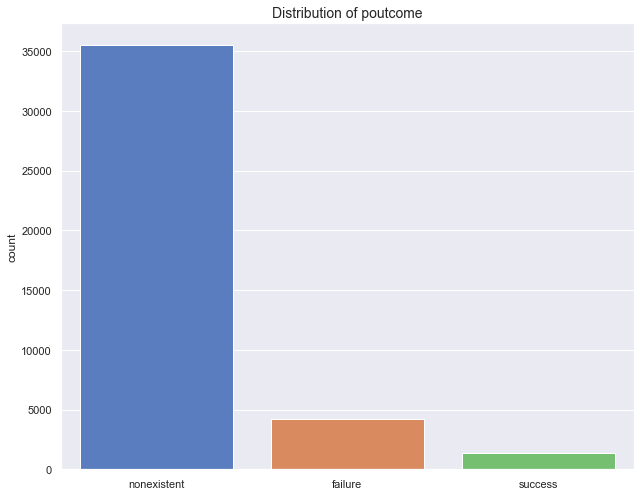

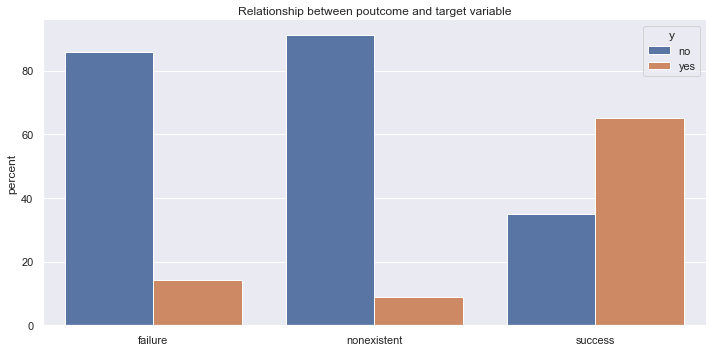

In [51]:
plot_cat_both('poutcome',df)

We can clearly see that "poutcome" influences our target variable, especially when it comes to "success".

### Multivariate analysis

#### Relationships between continuous variables

<AxesSubplot:>

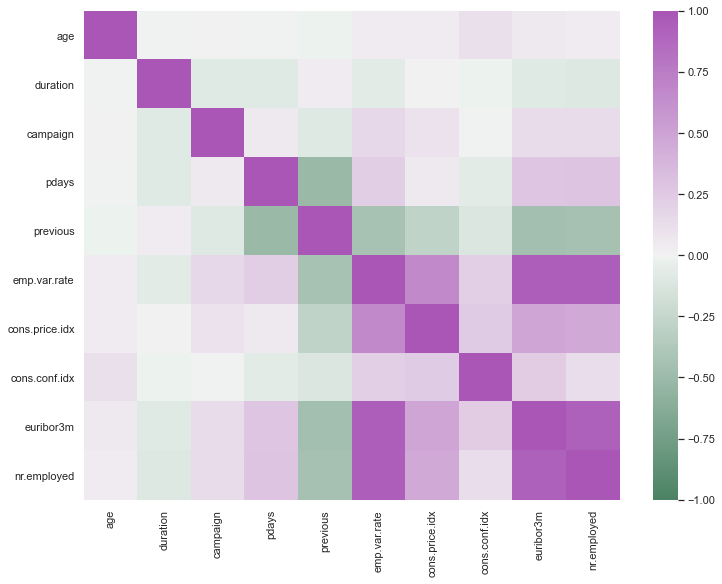

In [52]:
# correlation - we use Spearman's method because some of our numerical variables could be considered as ordinal
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(df_num.corr(method='spearman'), vmin=-1, vmax=1, cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True)) 

We can observe more significant correlation in lower right corner - between variables *previous, emp.var.rate, cons.price.idx, euribor3m, nr.employed* and between *pdays* and *previous*. Let's take a closer look at relationships between them.

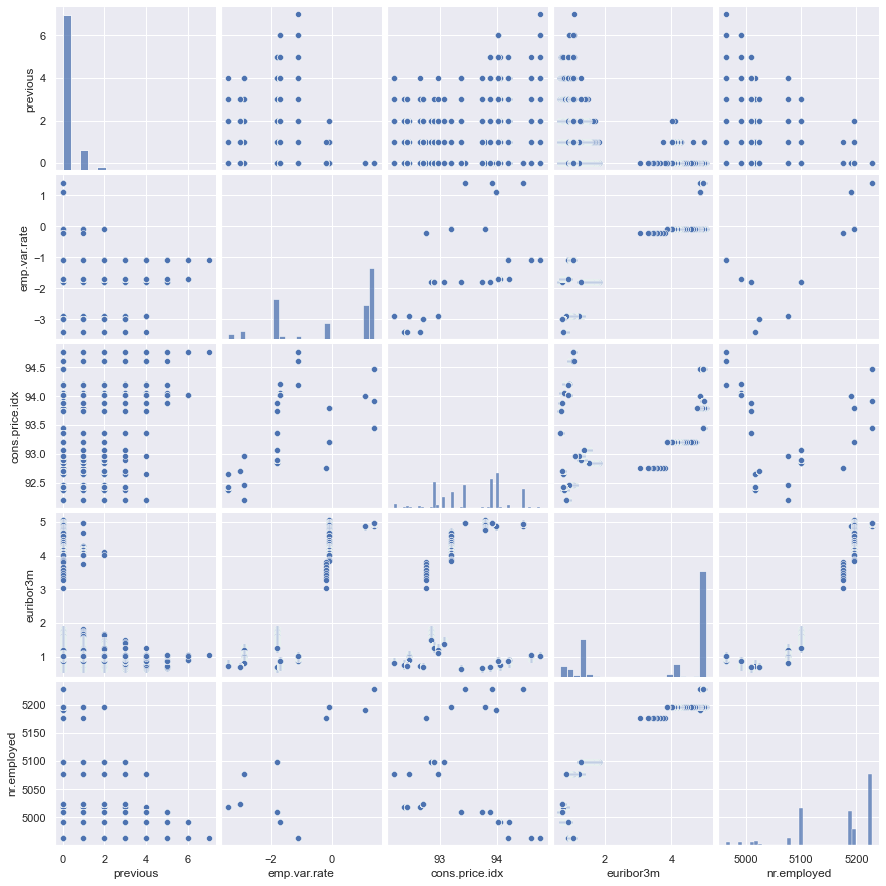

In [53]:
sns.pairplot(df_num.loc[:,["previous", "emp.var.rate", "cons.price.idx", "euribor3m", "nr.employed"]])

<AxesSubplot:xlabel='pdays', ylabel='previous'>

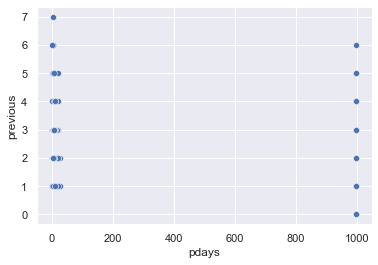

In [54]:
sns.scatterplot(data=df, x="pdays", y="previous")

Indeed, there's some kind of relation between the most correlated variables (euribor3m, emp.var.rate, nr.employed).

#### Relationships between categorical variables 

<AxesSubplot:xlabel='marital', ylabel='count'>

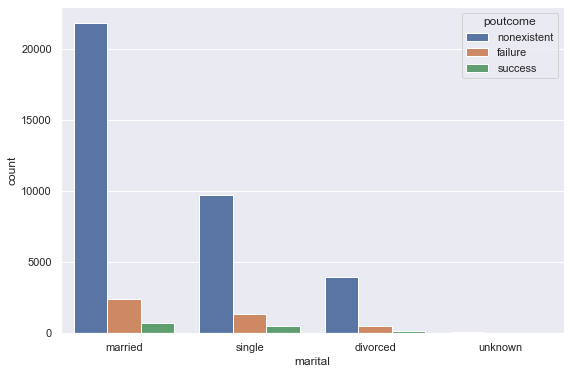

In [55]:
plt.figure(figsize=(9, 6))
sns.countplot(x="marital", hue="poutcome", data=df) # no relation 

<AxesSubplot:xlabel='month', ylabel='count'>

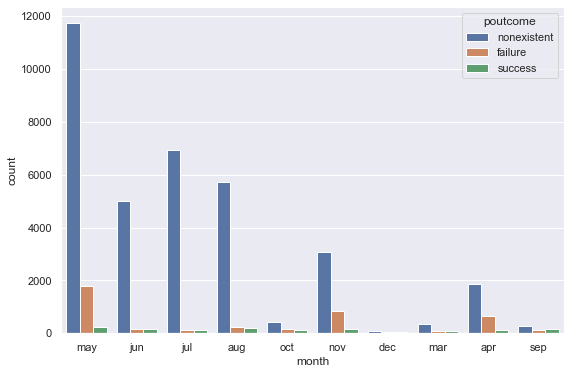

In [56]:
plt.figure(figsize=(9, 6))
sns.countplot(x="month", hue="poutcome", data=df) # there seems to be a relation 

#### Additional analysis

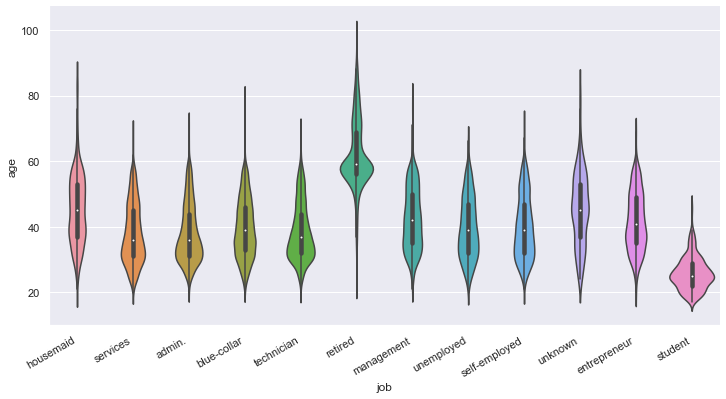

In [57]:
plot = sns.catplot(x="job", y="age", kind="violin", data=df, height=5, aspect=2)
plot.set_xticklabels(rotation=30, ha="right") 
# no meaningful info - retired and student distinguish as expected 

In [58]:
pv = df.pivot_table(columns=['job'], index=['day_of_week'], values=['duration'], aggfunc='mean', fill_value=0)
pv

duration                                                   \
job              admin. blue-collar entrepreneur   housemaid  management   
day_of_week                                                                
fri          248.229868  261.261089   251.771218  234.983516  243.291902   
mon          243.384830  248.701897   258.683230  223.043860  241.301562   
thu          262.905669  276.258612   243.779503  247.777778  273.000000   
tue          250.923758  268.058724   287.859848  266.798319  276.487091   
wed          266.286837  268.033520   279.061372  277.116822  251.499145   

                                                                           \
job             retired self-employed    services     student  technician   
day_of_week                                                                 
fri          255.567568    269.616487  248.860000  294.493827  250.521183   
mon          259.985632    250.151613  251.476019  294.768362  240.455596   
thu          274.765823    266.238095  271.171084  283.898477  253.650804   
tue          281.252660    254.513725  260.603535  265.918605  253.299473   
wed          296.872464    283.066390  259.643890  279.491018  253.644306   

                                     
job          unemployed     unknown  
day_of_week                          
fri          240.090000  208.189189  
mon          239.397959  238.038462  
thu          264.069565  266.633803  
tue          229.601990  216.756757  
wed          273.358289  255.028571

[Text(0.5, 0, 'duration-admin.'),
 Text(1.5, 0, 'duration-blue-collar'),
 Text(2.5, 0, 'duration-entrepreneur'),
 Text(3.5, 0, 'duration-housemaid'),
 Text(4.5, 0, 'duration-management'),
 Text(5.5, 0, 'duration-retired'),
 Text(6.5, 0, 'duration-self-employed'),
 Text(7.5, 0, 'duration-services'),
 Text(8.5, 0, 'duration-student'),
 Text(9.5, 0, 'duration-technician'),
 Text(10.5, 0, 'duration-unemployed'),
 Text(11.5, 0, 'duration-unknown')]

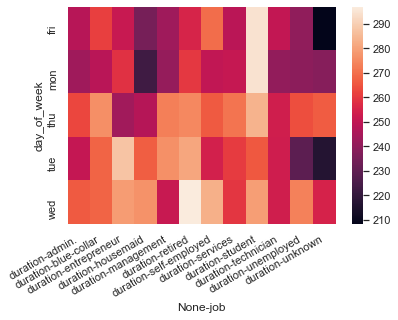

In [59]:
plot = sns.heatmap(pv)
plot.set_xticklabels(plot.get_xticklabels(),rotation=30, ha="right")

We can see some interesting dependencies between day_of_week and job in terms of duration, e.g. monday for housmaids is not a good day for contact. Let's now try introducing a new variable, based on month.

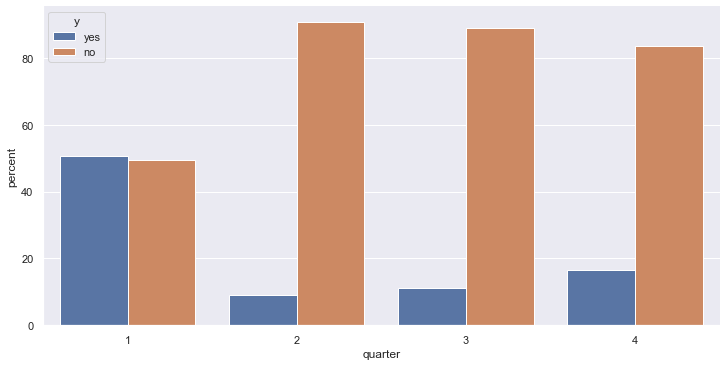

In [60]:
import copy
temp = copy.deepcopy(df)
temp["quarter"] = 0
temp.loc[(temp.month=="jan") | (temp.month=="feb") | (temp.month=="mar"),'quarter'] = 1
temp.loc[(temp.month=="apr") | (temp.month=="may") | (temp.month=="jun"),'quarter'] = 2
temp.loc[(temp.month=="jul") | (temp.month=="aug") | (temp.month=="sep"),'quarter'] = 3
temp.loc[(temp.month=="oct") | (temp.month=="nov") | (temp.month=="dec"),'quarter'] = 4

temp['quarter'] = temp['quarter'].astype(object)
temp2 = temp.groupby('quarter')["y"].value_counts(normalize=True).mul(100).rename('percent').reset_index()
plot = sns.catplot(data=temp2, x='quarter', y='percent', hue="y", kind='bar', height=5, aspect=2, legend_out=False)

It seems like a good idea to add this variable, however, in our data in 1 quarter there's only march, and it's a very small fraction, so the chart above is a bit misleading. Excluding march gives us no distinct relation.

## Data Preprocessing

### Missing values
 
There are no typical missing values in our data. However, some of our categorical variables have values encoded as "unknown" and we treat them as missings. We will deal with them using different techniques and knowledge from previous section. 

In [61]:
# delete:
# job, marital - small fraction of missing
# housing, loan - a bit bigger fraction, but the same records in both cases
df_miss = df[(df.job!="unknown") & (df.marital!="unknown") & (df.housing!="unknown") & (df.loan!="unknown")]

In [62]:
# impute:
# education - 4% and similar fraction to one of the variables
# later on, parallel to encoding (pipeline)

In [63]:
df_miss.shape

(39791, 21)

### Outliers

From the EDA section we know that there's plenty of outliers in our data. Mostly they were identified in univariate analysis, multivariate one didn't show much of them (they were hard to identify).

In [64]:
# numerical:
# age > 70, duration > 1000, campaign > 10, previous > 2
df_out = df_miss.drop(df_miss.loc[df_miss['age']>70].index)
df_out = df_out.drop(df_out.loc[df_out['duration']>1000].index)
df_out = df_out.drop(df_out.loc[df_out['campaign']>10].index)
df_out = df_out.drop(df_out.loc[df_out['previous']>2].index)

In [65]:
# categorical:
# education - illiterate; only 18 records in this category
df_out = df_out.drop(df_out.loc[df_out['education']=="illiterate"].index)

In [66]:
# dropping unnecessary columns (pdays,default)
df_out = df_out.drop(['pdays','default'],axis=1)

In [67]:
print(df_out.shape)
print(len(df_out)/len(df)) # 90% of data left

(37362, 19)
0.9073732271225957


### Encoding

As we already know, we have some categorical variables in our dataset, which we need to encode in order to perform dimensionality reduction.

* **target encoding** - variables, which, after EDA, we expect to have impact on target
* **binarization** - variables taking only two values
* **one-hot-encoding** - the rest of categorical variables

After encoding we will also perform standarization.

In [68]:
df_out.columns

Index(['age', 'job', 'marital', 'education', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'duration', 'campaign', 'previous', 'poutcome',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'nr.employed', 'y'],
      dtype='object')

In [69]:
# target variable encoding
label_encoder = LabelEncoder()
df_out['y'] = label_encoder.fit_transform(df_out['y'])

In [70]:
# month variable - least numerous categories to "other"
df_out.loc[(df_out.month=="oct") | (df_out.month=="dec") | (df_out.month=="mar") | (df_out.month=="sep")]["month"] = "other"

In [71]:
# Splitting columns on groups to proper encoders
num_cols = ['age', 'duration', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
cat_cols = ['marital', 'education', 'day_of_week']
ord_cols = ['campaign', 'previous']
bin_cols = ['housing', 'loan', 'contact'] # for those ordinal will give us the same as LabelBinarizer, and is easier to use
target_cols = ['job', 'month', 'poutcome'] # categorical columns which have impact on our target variable

In [72]:
# Defining pipelines for preprocessing different groups
num_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('variance_trsh', VarianceThreshold(threshold=0.1))
])

cat_pipe = Pipeline([ # here the only imputation because we know only education need imputing
    ('imputer', SimpleImputer(missing_values="unknown", strategy='most_frequent', verbose=True)), 
    ('ohe', OneHotEncoder(sparse=False)) 
])

ord_pipe = Pipeline([
    ('encoder', OrdinalEncoder()),
    ('scaler', StandardScaler())
])

ord_bin_cols = ord_cols + bin_cols
pipe = ColumnTransformer(transformers=[
    ('cat', cat_pipe, cat_cols),
    ('ord', ord_pipe, ord_bin_cols),
    ('num', num_pipe, num_cols)
])

In [73]:
X = pipe.fit_transform(df_out)

In [74]:
# bin_pipe = LabelBinarizer() - same thing done above with ordinal encoder (easier to use)
# df_out['housing'] = bin_pipe.fit_transform(df_out['housing'])
# df_out['loan'] = bin_pipe.fit_transform(df_out['loan'])
# df_out['contact'] = bin_pipe.fit_transform(df_out['contact'])

target_pipe = Pipeline([
    ('encoder', TargetEncoder()),
    ('scaler', StandardScaler())
])

X2 = target_pipe.fit_transform(df_out[target_cols],df_out["y"])

In [75]:
X.shape

(37362, 26)

In [76]:
X2.shape

(37362, 3)

In [77]:
X = np.column_stack((X, X2))
X.shape

(37362, 29)

## DR

Having data prepared for dimensionality reduction, we will use 4 different methods - PCA, SVD, t-SNE and UMAP.

### PCA

In [78]:
# reduction
pca = PCA(n_components=2) # 2-dimensional space
X_pca = pca.fit_transform(X)

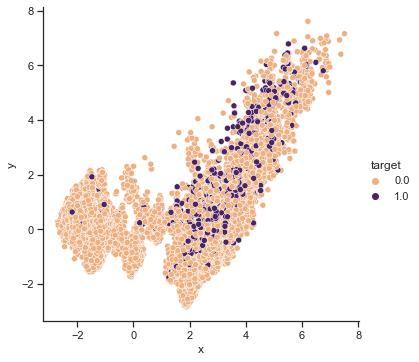

In [79]:
# visualization
plot_df = pd.DataFrame.from_records(data=X_pca[:,:2],columns=["x","y"])
plot_df["target"] = df_out["y"]

sns.set(style="ticks")
sns.relplot("x", "y", data=plot_df, hue="target", palette="flare")

In [80]:
print(pca.explained_variance_ratio_) # percentege of variance explained by each component
print(pca.explained_variance_ratio_.sum()) # total

[0.25911228 0.08350308]
0.34261535842951585


By reducing out data to 2 components we explain 34% of variance, which is not much. Let's see what is the best number of components.

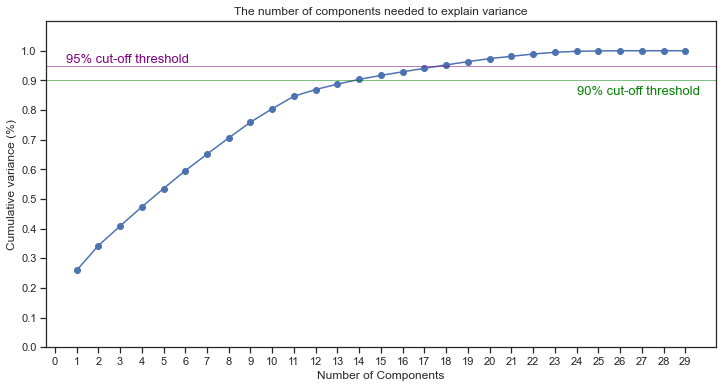

In [81]:
n_ticks = X.shape[1] + 1 # number of features after encoding

pca2 = PCA()
pca2.fit_transform(X)
fig, ax = plt.subplots(figsize=(12, 6))
x_ticks = np.arange(1, n_ticks, step=1)
exp_var = np.cumsum(pca2.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(x_ticks, exp_var, marker='o', color='b')
plt.xlabel('Number of Components')
plt.xticks(np.arange(0, n_ticks, step=1))
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='purple', linewidth=0.5)
plt.text(0.5, 0.96, '95% cut-off threshold', color = 'purple', fontsize=13)
plt.axhline(y=0.90, color='green', linewidth=0.5)
plt.text(24, 0.85, '90% cut-off threshold', color = 'green', fontsize=13)
plt.show()

In [82]:
pca = PCA(n_components=0.95).fit(X) # how much variance we want explained
len(pca.explained_variance_ratio_) # almost as many components as features that originally our dataset constisted of

18

In [83]:
pca = PCA(n_components=0.90).fit(X) 
len(pca.explained_variance_ratio_)

14

In [84]:
pca = PCA(n_components=11).fit(X) # for this number of components the biggest change in gradient of the line 
sum(pca.explained_variance_ratio_)

0.8467686453229514

Now it depends on us, preserving how much variance we care about. Given the size of the preprocessed dataset (29 feautres) and the original one (21) both options - 14 and 18 components - seem good.

### SVD

In [85]:
# reduction
svd = TruncatedSVD(n_components=2, algorithm='arpack')
svd_X = svd.fit_transform(X)

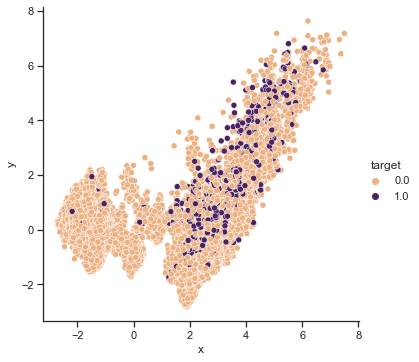

In [86]:
# visualization
plot_df = pd.DataFrame.from_records(data=svd_X[:,:2],columns=["x","y"])
plot_df["target"] = df_out["y"]

sns.set(style="ticks")
sns.relplot("x", "y", data=plot_df, hue="target", palette='flare')

In [87]:
print(svd.explained_variance_ratio_) # percentege of variance explained by each component
print(svd.explained_variance_ratio_.sum()) # total

[0.25911215 0.08345625]
0.34256839414337076


Same as PCA - about 34% of variance explained; not much.

### t-SNE (with PCA first)

In [88]:
pca = PCA(n_components=0.90)
new_X = pca.fit_transform(X)
# pca before t-sne - structure preserved, faster computation because less features
tsne = TSNE(n_components=2)
tsne_X_pca = tsne.fit_transform(new_X)

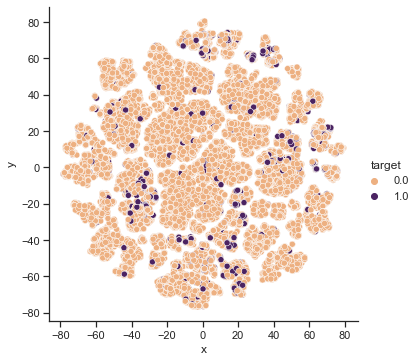

In [89]:
# visualization
plot_df = pd.DataFrame.from_records(data=tsne_X_pca,columns=["x","y"])
plot_df["target"] = df_out["y"]

sns.set(style="ticks")
sns.relplot("x", "y", data=plot_df, hue="target", palette='flare')

### UMAP

In [90]:
# reduction
embedding = umap.UMAP(n_neighbors=20,
                      min_dist=0.15).fit_transform(X)

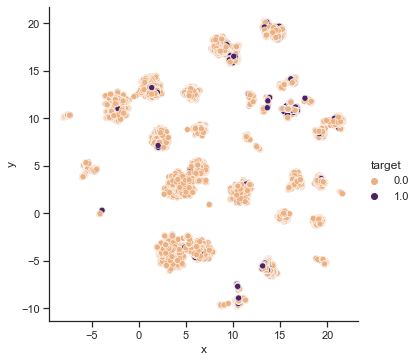

In [91]:
# visualization
plot_df = pd.DataFrame.from_records(data=embedding,columns=["x","y"])
plot_df["target"] = df_out['y']

sns.set(style="ticks")
sns.relplot("x", "y", data=plot_df, hue="target", palette="flare")

## Summary

To sum up our work so far, we performed following steps:

* exploratory analysis - distribution, anomalies & relations between variables
* dropping outliers and missing (or imputing) + dropping 2 meaningless columns
* encoding and standarization
* 4 different dimensionality reduction techniques performed, turned out that 14-18 components explain 90-95% procent of variance

Given the size of the dataset and steps taken above, we can conclude that there are some features in the dataset, apart from two that were already dropped, that probably give us no useful information for prediction of "y" and we could drop them as well. Also, our target variable is highly imbalanced, which could also be a problem in further steps.